In [22]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [23]:
from PIL import Image

In [24]:
img1 = Image.open("1.jpg")

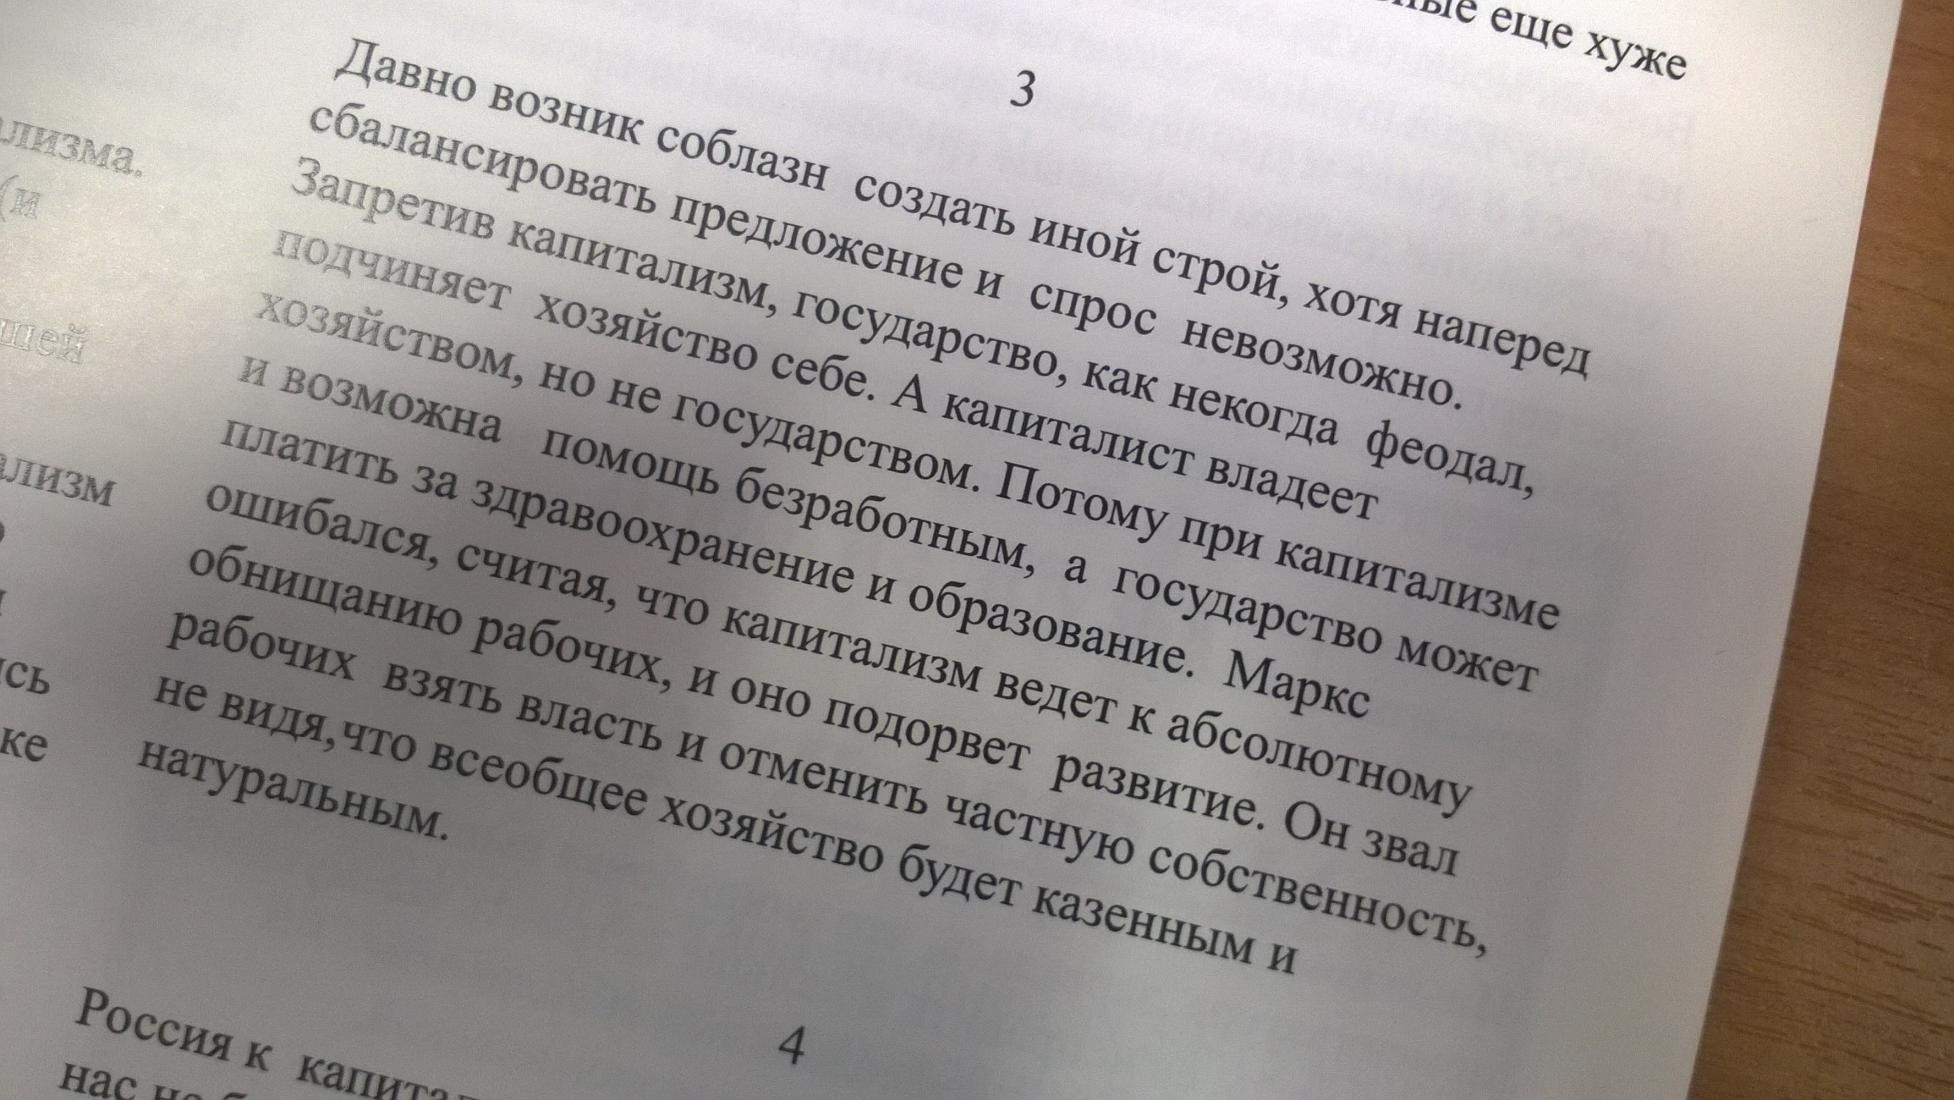

In [25]:
img1

In [26]:
img1 = np.array(img1)

In [7]:
img1.shape

(1100, 1954, 3)

In [404]:
# def _gray_scale(img):
#     weights = np.array([0.299, 0.587, 0.114])
#     return img @ weights


def preprocess_for_fht(img, flip=False):
    """
    Предобработка: убирает шум, вычисляет градиенты с помощью 
    оператора Собеля, обрезает изображение, чтобы ширина была степенью двойки
    """
    img = np.array(img)
    img = cv.GaussianBlur(img, (3, 3), 0)
    
    if flip: 
        img = np.flip(img, axis=1)
    
    # gray = _gray_scale(img)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    grad_x = cv.Sobel(gray, 3, 1, 0, ksize=3)
    grad_y = cv.Sobel(gray, 3, 0, 1, ksize=3)
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    H, W = grad.shape
    W = 2 ** int(np.log2(W))
    return np.array(grad[:, :W], dtype=np.float32)


def calc_fht(img, flip=False):
    """
    Вычисляет быстрое преобразование Хафа
    """
    grad = preprocess_for_fht(img, flip=flip)
    H, W = grad.shape
    
    def process_strip(img, l, r):
        """
        Вычисляет быстрое преобразование Хафа для полосы
        """
        strip_width = r - l
        if strip_width == 1:
            return img[:, l:r]

        fht = np.zeros([H, strip_width])
        left_substrip = process_strip(img, l, (l + r) // 2)
        right_substrip = process_strip(img, (l + r) // 2, r)

        for y in range(H):
            for s in range(strip_width):    
                mid1 = s // 2
                if s % 2:
                    mid2 = mid1 + 1
                else:
                    mid2 = mid1
                fht[y, s] = left_substrip[y, mid1] + \
                            right_substrip[(y + mid2) % H, mid1]
        return fht
    
    return process_strip(grad, 0, W)


def find_max_variance(fht):
    """
    Находит максимальную дисперсию в fht 
    """
    var = np.var(fht, axis=0)
    argmax = np.argmax(var)
    return argmax, var[argmax]


def find_angle(fht, fht_flipped):
    """
    Находит синус и косинус угла, на который надо повернуть изображение
    """
    shift, variance = find_max_variance(fht)
    shift_flipped, variance_flipped = find_max_variance(fht_flipped)
    if variance > variance_flipped:
        print('Normal')
        leg = fht.shape[1]
        hypotenuse = np.sqrt(shift ** 2 + leg ** 2)
        sin_a = shift / hypotenuse
        cos_a = leg / hypotenuse
        return cos_a, -sin_a
    else:
        print('Flipped')
        leg = fht_flipped.shape[1]
        hypotenuse = np.sqrt(shift_flipped ** 2 + leg ** 2)
        sin_a = shift_flipped / hypotenuse
        cos_a = leg / hypotenuse
        return cos_a, sin_a


def coords_before_transform(x, y, w, h, cos_a, sin_a):
    """
    width, height - размеры исходного изображения
    'a' - угол поворота
    
    Для пикселя x, y на повернутом изображении находит 
    "примерный" пиксель, который в него перешёл
    (вычисляет обратное преобразование к преобразованию 
    сдвиг -> поворот -> сдвиг обратно -> масштабирование)
    """
    # коэффициент масштабирования (находится из подобия)
    gamma = min(h / (h * np.abs(cos_a) + w * np.abs(sin_a)), w / (w * np.abs(cos_a) + h * np.abs(sin_a)))
    
    # обратное к масштабированию
    x *= gamma
    y *= gamma
    
    # обратное к сдвигу
    x -= w * gamma / 2.
    y -= h * gamma / 2.

    # обратное к повороту
    x, y = x * cos_a + y * sin_a, -x * sin_a + y * cos_a
    
    # обратное к сдвигу
    x += w / 2.
    y += h / 2.

    return x, y


def transform(img, cos_a, sin_a, interpolation_type='nearest_neighbor'):
    """
    Поворачивает изображение на угол 'a', заданный косинусом и синусом
    Вычисляет интенсивность пикселя с помощью интерполяции 
    interpolation_type - тип интерполяции (nearest_neighbor, bilinear)
    """
    img = np.array(img, dtype='float32')
    
    H, W, _ = img.shape
    res = np.zeros_like(img)
    for x in range(W):
        for y in range(H):
            x_old, y_old = coords_before_transform(x, y, W, H, cos_a, sin_a)        
            if interpolation_type == 'nearest_neighbor':
                # берём ближайший пиксель
                x_old = int(np.round(x_old))
                y_old = int(np.round(y_old))
               
                x_old = np.clip(x_old, 0, W - 1)
                y_old = np.clip(y_old, 0, H - 1)
                
                res[y, x, :] = img[y_old, x_old, :]
            else:
                # вычисляем 4 ближайших пикселя
                if int(x_old) == np.ceil(x_old):
                    x1 = int(x_old) - 1
                else:
                    x1 = int(x_old)
                x2 = x1 + 1
                
                if int(y_old) == np.ceil(y_old):
                    y1 = int(y_old) - 1
                else:
                    y1 = int(y_old)
                y2 = y1 + 1
                
                x1 = np.clip(x1, 0, W - 1)
                x2 = np.clip(x2, 0, W - 1)
                y1 = np.clip(y1, 0, H - 1)
                y2 = np.clip(y2, 0, H - 1)
            
                v11 = img[y1, x1, :]
                v12 = img[y2, x1, :]
                v21 = img[y1, x2, :]
                v22 = img[y2, x2, :]
                v1 = v11 + (x_old - x1) * (v21 - v11)
                v2 = v12 + (x_old - x1) * (v22 - v12)

                res[y, x, :] = np.clip(v1 + (y_old - y1) * (v2 - v1), 0, 255)
    return cv.convertScaleAbs(res)

In [405]:
def rotate_img_back(img, interpolation_type):
    fht = calc_fht(img)
    fht_flipped = calc_fht(img, flip=True)
    cos_a, sin_a = find_angle(fht, fht_flipped)
    res = transform(img, cos_a, sin_a, interpolation_type=interpolation_type)
    return res

In [357]:
fht = calc_fht(img1)

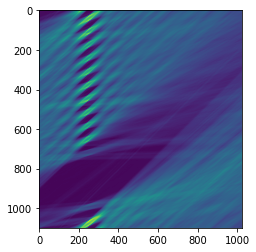

In [358]:
plt.imshow(fht)
plt.show()

In [361]:
fht_flipped = calc_fht(img1, flip=True) 

In [363]:
cos_a, sin_a = find_angle(fht, fht_flipped)

Normal


In [364]:
res = transform(img1, cos_a, sin_a, interpolation_type='nearest_neighbor')

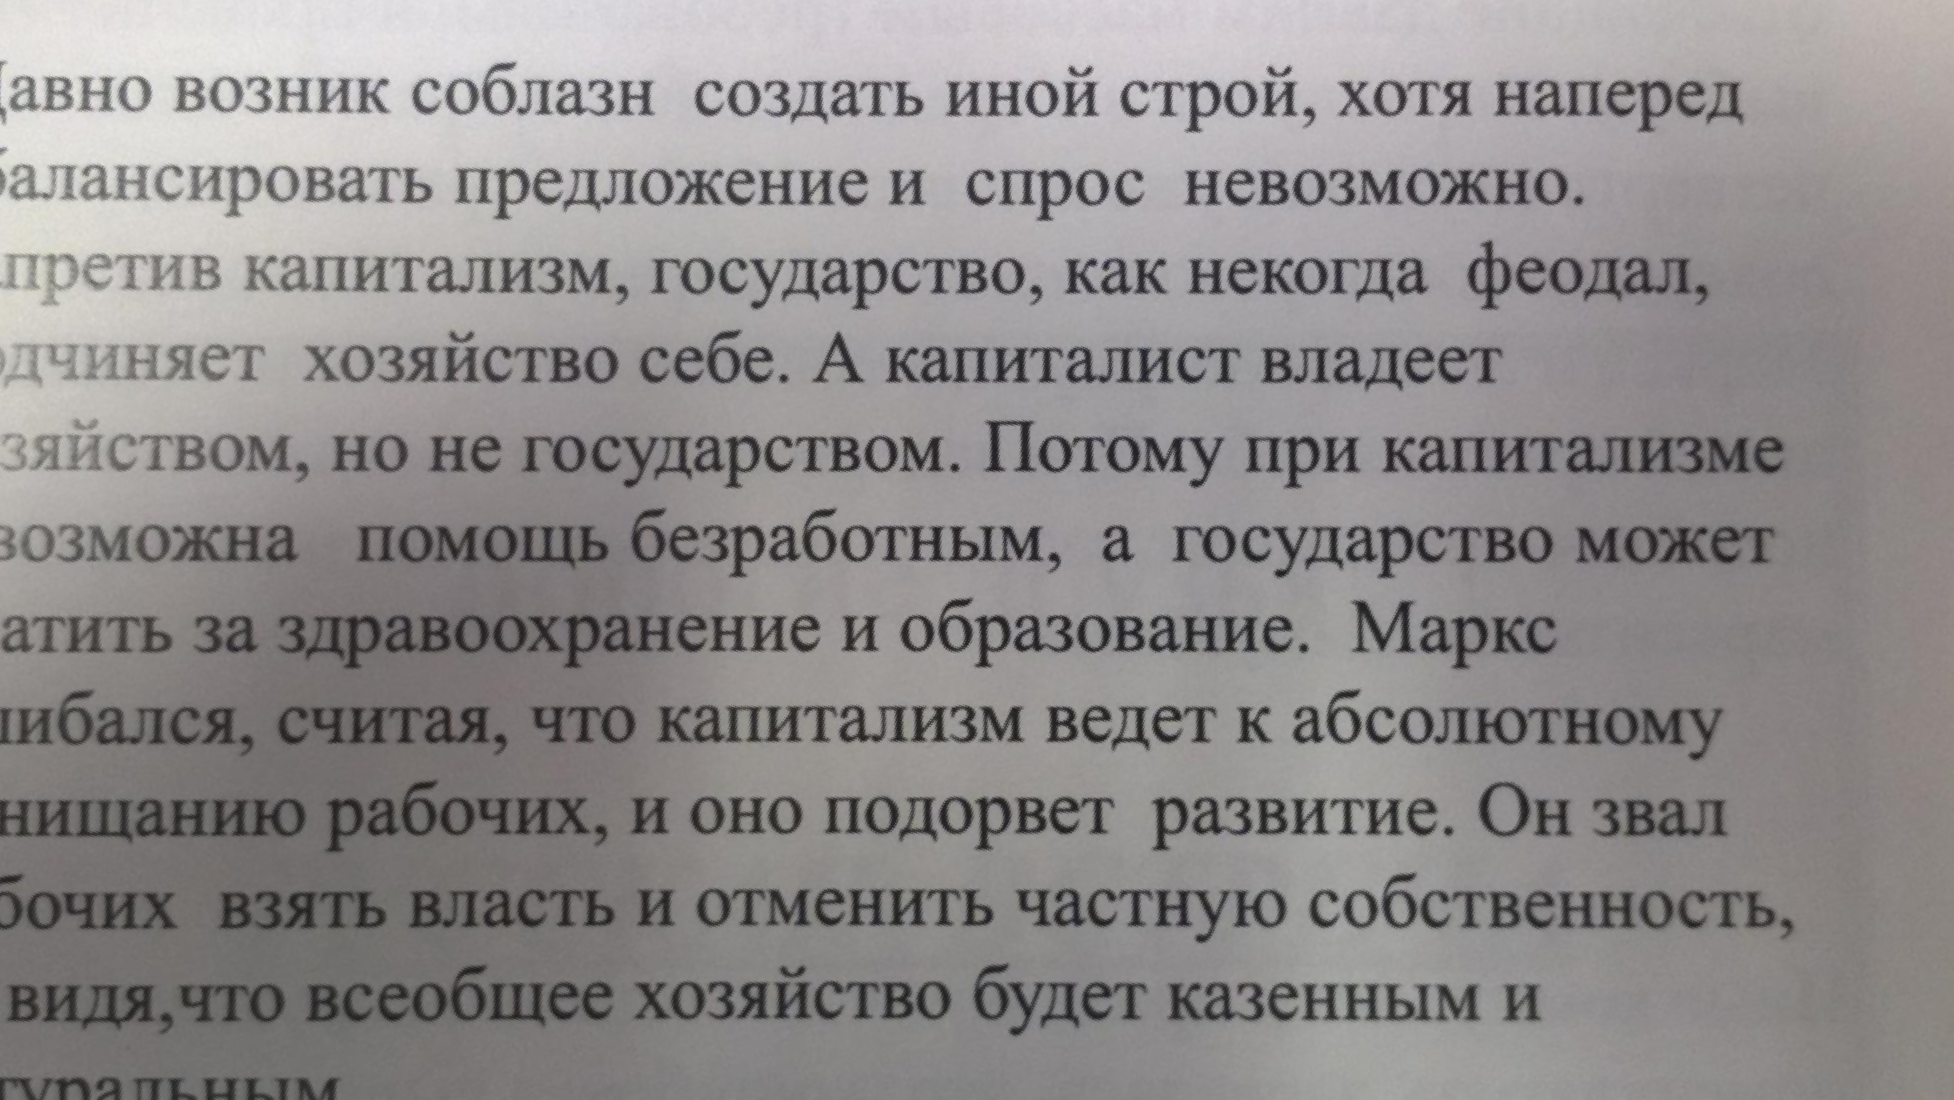

In [365]:
Image.fromarray(res)

In [175]:
res = transform(img1, cos_a, sin_a, interpolation_type='bilinear')

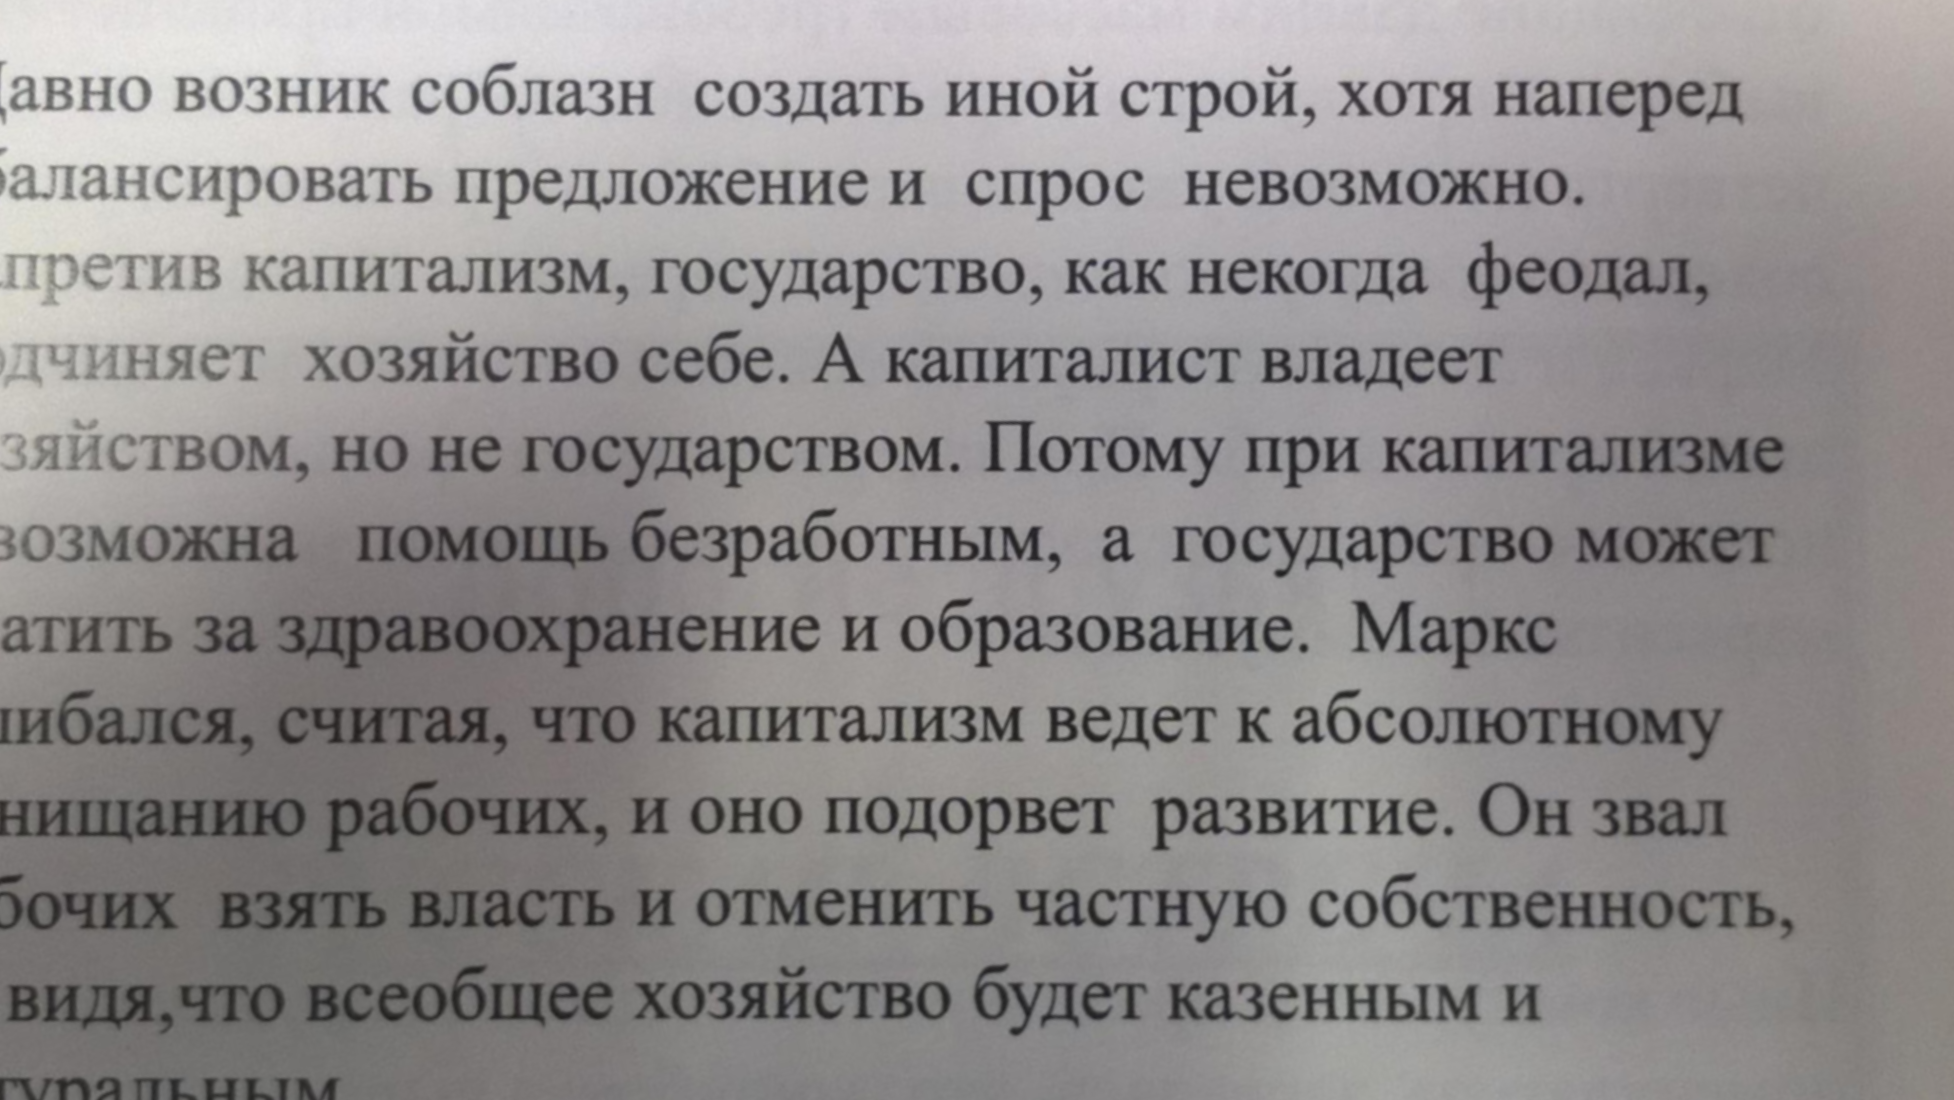

In [177]:
Image.fromarray(res)

### Время работы

In [91]:
degrees = 2 ** np.arange(1, 11)
degrees

array([   2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

In [93]:
grad = preprocess_for_fht(img7)

In [95]:
H = grad.shape[0]

In [96]:
def process_strip(img, l, r):
    """
    Вычисляет быстрое преобразование Хафа для полосы
    """
    strip_width = r - l
    if strip_width == 1:
        return img[:, l:r]

    fht = np.zeros([H, strip_width])
    left_substrip = process_strip(img, l, (l + r) // 2)
    right_substrip = process_strip(img, (l + r) // 2, r)

    for y in range(H):
        for s in range(strip_width):    
            mid1 = s // 2
            if s % 2:
                mid2 = mid1 + 1
            else:
                mid2 = mid1
            fht[y, s] = left_substrip[y, mid1] + \
                        right_substrip[(y + mid2) % H, mid1]
    return fht

In [178]:
from time import time
times = []
for d in degrees:
    t_0 = time()
    process_strip(grad, 0, d)
    times.append(time() - t_0)

In [98]:
times

[0.007581949234008789,
 0.01535797119140625,
 0.029822826385498047,
 0.04484128952026367,
 0.08779597282409668,
 0.2072141170501709,
 0.4762709140777588,
 1.079401969909668,
 2.4057421684265137,
 5.320909023284912]

In [103]:
sizes = np.array(degrees * H, dtype=np.float32)
sizes /= 1000000

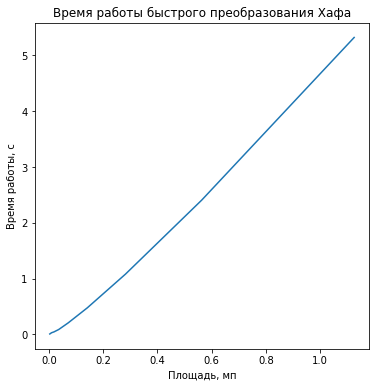

In [108]:
plt.figure(figsize=(6, 6))
plt.title('Время работы быстрого преобразования Хафа')
plt.xlabel('Площадь, мп')
plt.ylabel('Время работы, с')
plt.plot(sizes, times)
plt.show()

### Для улучшения работы алгоритма применил предобработку: убрал шум с помощью Gaussian Blur, оставил градиенты c помощью оператора Собеля 

In [ ]:
for i in range(3, 11):
    img = Image.open(f"{i}.jpg")
    interpolation_type = 'nearest_neighbor'
    res = rotate_img_back(img, interpolation_type=interpolation_type)
    Image.fromarray(np.array(np.clip(res, 0, 255), dtype=np.uint8)).save(f'{i}_rotated_{interpolation_type}.jpg')

Flipped


In [211]:
# for i in range(1, 11):
#     img = Image.open(f"{i}.jpg")
#     interpolation_type = 'bilinear'
#     res = rotate_img_back(img, interpolation_type=interpolation_type)
#     Image.fromarray(np.array(np.clip(res, 0, 255), dtype=np.uint8)).save(f'{i}_rotated_{interpolation_type}.jpg')

In [392]:
from tqdm import trange
fhts = []
fhts_flipped = []

for i in trange(1, 11):
    img = Image.open(f"{i}.jpg")
    fht = calc_fht(img)
    fht_flipped = calc_fht(img, flip=True)
    fhts.append(fht)
    fhts_flipped.append(fht_flipped)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:50<00:00, 35.01s/it]


In [393]:
true_values = np.array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [397]:
values = []
for i in trange(10):
    fht = fhts[i]
    fht_flipped = fhts_flipped[i]
    
    var = np.var(fht, axis=0)
    var2 = np.var(fht_flipped, axis=0)
    
    argmax = np.argmax(var)
    argmax2 = np.argmax(var2)
    
    var = var[argmax]
    var2 = var2[argmax2]
    
    if var > var2:
        values.append(1)
    else:
        values.append(0)
values = np.array(values)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 85.12it/s]


In [399]:
values

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [398]:
np.allclose(values, true_values)

True